### Playing around with hard disk failure data

(source: Kaggle)

In [126]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                                 GeneralizedAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, SaliencybasedGeneralizedAnomalyScoreV2, 
                 FFTbasedGeneralizedAnomalyScoreV2, KMeansAnomalyScoreV2, MatrixProfileAnomalyScore)                 
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import networkx as nx

from pandas.plotting import register_matplotlib_converters
import seaborn as sns

from reliability.Distributions import (Weibull_Distribution,Competing_Risks_Model)
from reliability.Fitters import Fit_Weibull_2P, Fit_Weibull_3P, Fit_Everything, Fit_Weibull_CR
from reliability.Probability_plotting import (Normal_probability_plot, Weibull_probability_plot, 
        Exponential_probability_plot, QQ_plot_parametric, QQ_plot_semiparametric)

register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [10]:
#fd = pd.read_csv('./data/machine_failure_data.csv')
fd = pd.read_csv('./data/hard_drive_failure_data.csv')
fd

,@timestamp,@version,capacity_bytes,date,failure,model,serial_number,lifetime
0,2018-01-01T09:38:29.732Z,1,8.00156e+12,2017-04-18T21:00:00.000Z,1,ST8000DM002,ZA11WTAK,299
1,2018-01-01T09:38:01.463Z,1,2.50059e+11,2017-04-18T21:00:00.000Z,1,ST250LM004 HN,S2T0J9ACB00405,473
2,2018-01-01T09:57:00.561Z,1,4.00079e+12,2017-04-28T21:00:00.000Z,1,ST4000DM000,Z300GQJ1,483
3,2018-01-01T09:45:45.712Z,1,8.00156e+12,2017-04-20T21:00:00.000Z,1,ST8000DM002,ZA13QBYE,159
4,2018-01-01T09:49:00.954Z,1,4.00079e+12,2017-04-22T21:00:00.000Z,1,ST4000DM000,Z3040KMY,477
...,...,...,...,...,...,...,...,...
2982,2018-02-15T08:36:30.539Z,1,8.00156e+12,2017-12-13T22:00:00.000Z,1,ST8000DM002,ZA13R3T3,316
2983,2018-02-15T08:54:52.382Z,1,4.00079e+12,2017-12-24T22:00:00.000Z,1,ST4000DM000,Z3014P0L,724
2984,2018-02-15T08:55:11.378Z,1,1.20001e+13,2017-12-24T22:00:00.000Z,1,ST12000NM0007,ZCH03K2S,46
2985,2018-02-15T10:29:54.647Z,1,4.00079e+12,2017-12-25T22:00:00.000Z,1,ST4000DM000,S301GNPF,725


In [20]:
# focus on larger disks first
#lifetimes = fd[fd['capacity_bytes'] == 4000787030016.0]['lifetime'].values
lifetimes = fd[fd['capacity_bytes'] >= 8001563222016.0]['lifetime'].values
lifetimes = lifetimes[lifetimes > 0]
lifetimes

array([299, 159, 198, 144, 143,  25, 107, 106, 132, 213,   7,  58,  68,
        57,  52, 217, 272, 262, 111, 451,   3,  32, 183,  43, 400, 234,
       127, 405, 266,  24,  14, 103, 139, 152, 195, 114, 101, 490, 497,
       113,   3,   5,  23, 361, 417, 168,  13, 313,  31, 313,  19, 393,
       193, 116,  37, 159,  11,  71, 135,  98,  75,  68,  65, 186,  14,
       156,  21, 148,  18,  87, 138, 151,  67, 366,  38, 156, 248, 191,
        76,  52,   5,   6, 133, 103,  58, 130,   7,  31,  21, 376, 136,
       114, 521, 394, 489, 104, 323, 376, 319,  42,  35, 186, 183, 458,
        35,  97,  51,  70,  14, 389, 262, 207, 112,  50,  32, 438,   1,
       285,  30, 204,  54, 183,  88,  86,  80, 439, 177, 277, 276, 141,
        74,  86,  27, 136, 469,  16, 265, 125,  23, 160,   3,  98, 155,
        15, 249, 208,  21, 268, 166, 545, 107, 431, 484, 228,  48, 100,
       324, 245,   2,   3, 304,  18,  56, 378,  52,   4, 289,  40, 277,
        79,  80,   4,  47, 197, 324, 196, 351, 393, 225, 153,  1

### Fit a distribution

I cheated and used fit everything, the big loop
 `fit = Fit_Everything( ... `

and in the end the best distribution turned out to be Weibull competing risk, a product mixture of two Weibull distributions. 

The code makes us of Anderson-Darling as built-in goodness of fit test.

### Trying to understand how to fit the CR model

First, separate data into two group and fit a Weibull to each group

547 1
27.976212576212596 0.0002299497431874145


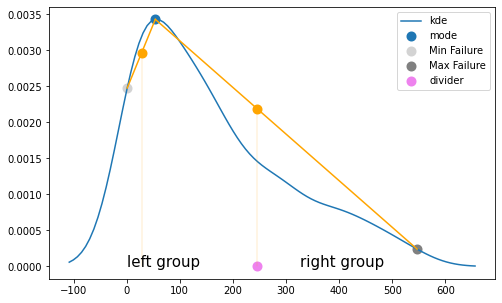

In [169]:
# finding the split point
#   I haven't found a reference for this method

max_failures = max(lifetimes)
min_failures = min(lifetimes)
print(max_failures, min_failures)

gkde = sp.stats.gaussian_kde(lifetimes)
delta = max_failures - min_failures
x_kde = np.linspace(min_failures - delta / 5, max_failures + delta / 5, 100)
y_kde = gkde.evaluate(x_kde)
peak_y = max(y_kde)
peak_x = x_kde[np.where(y_kde == peak_y)][0]


left_x = min_failures
left_y = gkde.evaluate(left_x)
left_m = (peak_y - left_y) / (peak_x - left_x)
left_c = -left_m * left_x + left_y
left_line_x = np.linspace(left_x, peak_x, 1000)
left_line_y = left_m * left_line_x + left_c  # y=mx+c
left_kde = gkde.evaluate(left_line_x)
left_diff = abs(left_line_y - left_kde)
left_diff_max = max(left_diff)
left_div_line = left_line_x[np.where(left_diff == left_diff_max)][0]
print(left_div_line, left_diff_max)

right_x = max_failures
right_y = gkde.evaluate(right_x)
right_m = (right_y - peak_y) / (right_x - peak_x)
right_c = -right_m * right_x + right_y
right_line_x = np.linspace(peak_x, right_x, 1000)
right_line_y = right_m * right_line_x + right_c  # y=mx+c
right_kde = gkde.evaluate(right_line_x)
right_diff = abs(right_line_y - right_kde)
right_diff_max = max(right_diff)
right_div_line = right_line_x[np.where(right_diff == right_diff_max)][0]

if left_diff_max > right_diff_max:
    dividing_line = left_div_line
else:
    dividing_line = right_div_line

#print(dividing_line, left_diff_max, right_diff_max)

max_left_point = left_line_y[np.where(left_diff == left_diff_max)][0]
max_right_point = right_line_y[np.where(right_diff == right_diff_max)][0]

plt.figure(figsize=(8, 5))

plt.plot(x_kde, y_kde, label='kde')
plt.scatter(peak_x, peak_y, lw=4, label='mode')
plt.plot(left_line_x, left_line_y, c='orange')
plt.scatter(left_x, left_y, lw=4, c='lightgrey', label='Min Failure')
plt.scatter(left_div_line, max_left_point, lw=4, c='orange')
plt.plot(right_line_x, right_line_y, c='orange')
plt.scatter(right_x, right_y, lw=4, c='grey', label='Max Failure')
plt.scatter(right_div_line, max_right_point, lw=4, c='orange')
plt.plot((left_div_line,left_div_line), (0, max_left_point), lw=0.4, alpha=0.5, c='orange')
plt.plot((right_div_line,right_div_line), (0, max_right_point), lw=0.4, alpha=0.5, c='orange')
plt.scatter(dividing_line, 0, lw=4, c='violet', label='divider')
plt.annotate('left group', xy=(min_failures, 0), fontsize=15)
plt.annotate('right group', xy=(dividing_line + 80, 0), fontsize=15)
#plt.hist(lifetimes, bins=30, alpha=0.1)


plt.legend()


In [152]:
lifetimes.sort()
group1 = lifetimes[lifetimes < dividing_line]
group2 = lifetimes[lifetimes >= dividing_line]
#group1 = lifetimes[lifetimes < 100]
#group2 = lifetimes[lifetimes >= 100]
fit1 = Fit_Weibull_2P(failures=group1, show_probability_plot=False)
fit2 = Fit_Weibull_2P(failures=group2, show_probability_plot=False)

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 182/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         96.7862         6.19043   85.3828   109.712
     Beta         1.21312       0.0751535   1.07441   1.36973 

Goodness of fit    Value
 Log-likelihood -999.173
           AICc  2002.41
            BIC  2008.75
             AD  2.35135 

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 63/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         397.084         11.6346   374.923   420.555
     Beta         4.56063        0.435101   3.78284   5.49836 

Goodness of fit    Value
 Log-likelihood -370.628
           AICc  745.456
            BIC  749.542
             AD  1.43444 



In [153]:
import autograd.numpy as anp
from autograd import value_and_grad
from autograd.differential_operators import hessian
from autograd.scipy.special import gamma as agamma
from autograd.scipy.special import beta as abeta
from autograd.scipy.special import erf

from reliability.Utils import (MLE_optimization)

def logf(t, a1, b1, a2, b2):  # Log PDF (Competing Risks)
    return anp.log(
        -(-(b2 * (t / a2) ** b2) / t - (b1 * (t / a1) ** b1) / t)
        * anp.exp(-((t / a2) ** b2) - (t / a1) ** b1)
    )

def logR(t, a1, b1, a2, b2):  # Log SF (Competing Risks)
    return -((t / a1) ** b1) - ((t / a2) ** b2)

def LL(params, T_f, T_rc):
    # Log Likelihood function (Competing Risks)
    LL_f = logf(
        T_f, params[0], params[1], params[2], params[3]
    ).sum()
    LL_rc = logR(
        T_rc, params[0], params[1], params[2], params[3]
    ).sum()
    return -(LL_f + LL_rc)


In [154]:
MLE_results = MLE_optimization(
            func_name="Weibull_CR",
            LL_func=LL,
            initial_guess= [fit1.alpha, fit1.beta, fit2.alpha, fit2.beta],
            failures=lifetimes,
            right_censored=[],
            optimizer="L-BFGS-B"
        )

In [159]:
alpha_1 = MLE_results.alpha_1
beta_1 = MLE_results.beta_1
alpha_2 = MLE_results.alpha_2
beta_2 = MLE_results.beta_2
dist_1 = Weibull_Distribution(alpha=alpha_1, beta=beta_1)
dist_2 = Weibull_Distribution(alpha=alpha_2, beta=beta_2)
full_dist = Competing_Risks_Model(distributions=[dist_1, dist_2])
alpha_1, beta_1, alpha_2, beta_2

(172.94797770566413, 0.957049189647462, 490.45449936515865, 8.52535973759446)

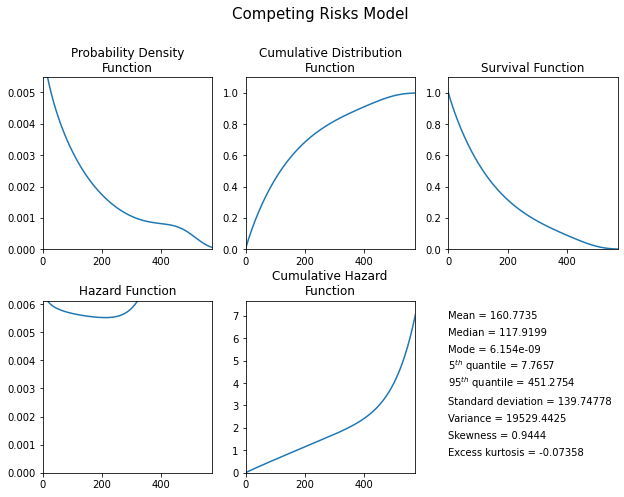

In [160]:
full_dist.plot()

[1.8269036618216599, 0.42817888813121946, 392.5863417260802]

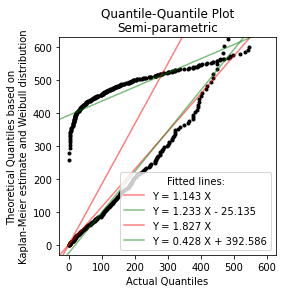

In [168]:
QQ_plot_semiparametric(X_data_failures=lifetimes, Y_dist=dist_1)  #doesn't work with CR model
QQ_plot_semiparametric(X_data_failures=lifetimes, Y_dist=dist_2)

Results from Fit_Weibull_CR (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 245/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
  Alpha 1         172.948         13.1253   149.044   200.684
   Beta 1         0.95705       0.0609398  0.844763   1.08426
  Alpha 2         490.455         24.3497   444.979   540.579
   Beta 2         8.52544         3.35136   3.94557   18.4215 

Goodness of fit    Value
 Log-likelihood -1480.12
           AICc   2968.4
            BIC  2982.24
             AD 0.266007 



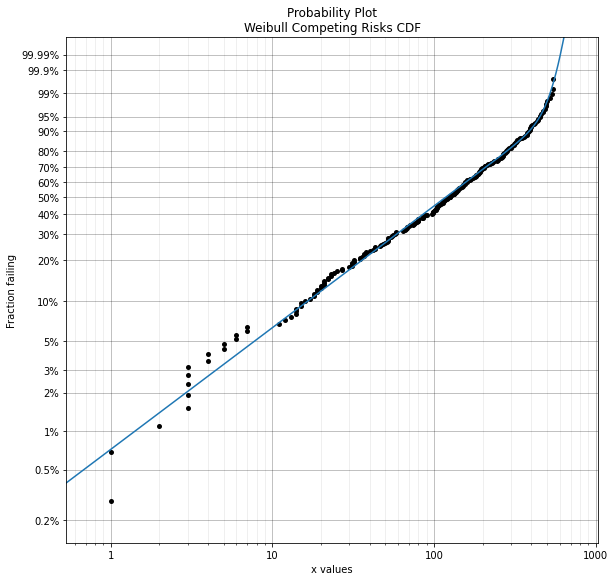

In [157]:
fit = Fit_Weibull_CR(
                    failures=lifetimes,
                    right_censored=None,
                    #show_probability_plot=False,
                    #print_results=False,
                    )
plt.show()